# <font color="blue">Project 2: DoppelGanger Find your Celebrity Look-Alike </font>
We have seen how face Recognition algorithms work. In short, they convert a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

### <font color="green">Your Task</font>
In this project, we will build a Fun Application - We will use the Face Embeddings to **find a doppelganger or look-alike to a given person.** Specifically, we will give you images of two persons and a celebrity dataset. Your task will be to find their celebrity look-alike. The first person is **Sofia Solares** who looks like the American Singer **Selena Gomez** and the second one is **Shashikant Pedwal** who looks like Indian Film Actor **Amitabh Bachchan**.

Given below is the Expected Output. 

### <font color="green">Expected Output</font>

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-selena.jpg)

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-amitabh.jpg)


By now, you should be able to discern what the problem is, and how you are going to solve it. You simply need a dataset which has enough celebrity faces and use face embeddings to match the test image with the celebrity face embeddings. That's enough Hint!

## <font color="blue">The Dataset</font>
There are many datasets which contain images of celebrities. Some of them are:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, we have curated a small dataset for this experiment.

We will use a subset of the Query set of the Celebrity Together Dataset in this project. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset we have created is using 5 images per celebrity and it has been saved in the **`../resource/asnlib/publicdata/celeb_mini`** folder. It is ~70MB in size. We have also provided a **`celeb_mapping.npy`** file which has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```


## <font color="blue">Marks Distribution </font>
1. **Implementation - 70 Marks**
1. **Video Explanation - 30 marks**

#### <font color="red">Note that you are free to use any other dataset if you have the resources of space and compute to handle the large datasets.</font>


In [1]:
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects

#### <font color="red">You are free to use other face recognition models as well. </font>

In [3]:
# Download dlib models
# Landmark model
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
# Face recognition model
!wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

--2021-08-29 17:28:37--  https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2021-08-29 17:28:37--  https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M   165MB/s    in 0.4s 

## <font color="blue">Explore Data </font>
In this section, we provide sample code of how to load the images and use the label mapping for your reference. This should help you get started with handling images and finding the embeddings.

In [4]:
!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
!unzip celeb_mini.zip

!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
!unzip test-images.zip

Streaming output truncated to the last 5000 lines.
   creating: celeb_mini/n00000156/
  inflating: celeb_mini/n00000156/n00000156_00000429.JPEG  
  inflating: celeb_mini/n00000156/n00000156_00000464.JPEG  
  inflating: celeb_mini/n00000156/n00000156_00000645.JPEG  
  inflating: celeb_mini/n00000156/n00000156_00000096.JPEG  
  inflating: celeb_mini/n00000156/n00000156_00000014.JPEG  
   creating: celeb_mini/n00000448/
  inflating: celeb_mini/n00000448/n00000448_00000586.JPEG  
  inflating: celeb_mini/n00000448/n00000448_00000267.JPEG  
  inflating: celeb_mini/n00000448/n00000448_00000400.JPEG  
  inflating: celeb_mini/n00000448/n00000448_00000375.JPEG  
  inflating: celeb_mini/n00000448/n00000448_00000314.JPEG  
   creating: celeb_mini/n00000073/
  inflating: celeb_mini/n00000073/n00000073_00000220.JPEG  
  inflating: celeb_mini/n00000073/n00000073_00000369.JPEG  
  inflating: celeb_mini/n00000073/n00000073_00000148.JPEG  
  inflating: celeb_mini/n00000073/n00000073_00000386.JPEG  
  in

In [5]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'
# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

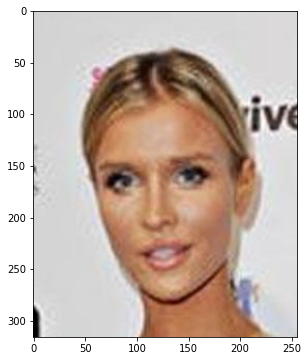

File path = celeb_mini/n00001116/n00001116_00000326.JPEG
Celeb Name: Joanna Krupa


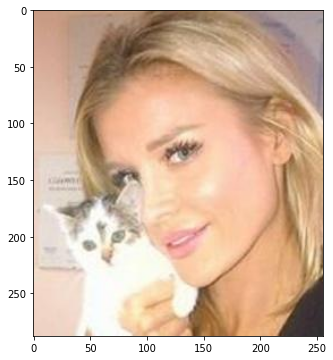

File path = celeb_mini/n00001116/n00001116_00000872.JPEG
Celeb Name: Joanna Krupa


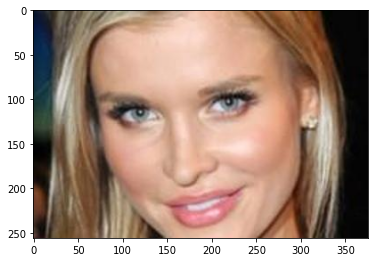

File path = celeb_mini/n00001116/n00001116_00000501.JPEG
Celeb Name: Joanna Krupa


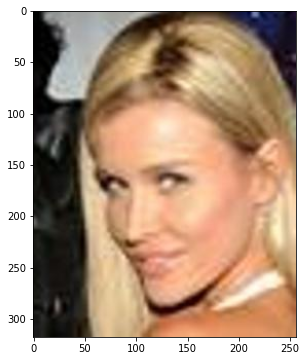

File path = celeb_mini/n00001116/n00001116_00000921.JPEG
Celeb Name: Joanna Krupa


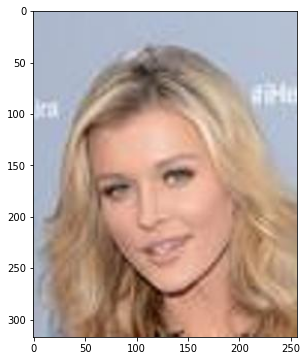

File path = celeb_mini/n00001116/n00001116_00000166.JPEG
Celeb Name: Joanna Krupa


In [6]:
# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

# Read each image and display along with the filename and celeb name
for file in imagefiles:
#     Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#     Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))

In [21]:
random_folder

'n00001116'

## <font color="blue">TODO</font>
You have to write the code for enrollment and testing to get the desired output as shown in the intro section.

**You can take help from the code we had provided in week 4 material.**

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from RGB to BGR, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [7]:
#YOUR CODE HERE
# Load all the models we need: a detector to find the faces, a shape predictor
# to find face landmarks so we can precisely localize the face, and finally the
# face recognition model.

 # Compute the 128-dimension face encoding for each faces
def encode_faces(path_):
    # Known face dataset
    faces_encodings = {}
    # All the folders inside the path
    allCelebs = [d for d in os.listdir(path_)
                    if os.path.isdir(os.path.join(path_, d))]
    # For each folder
    for i, celebID in enumerate(allCelebs):
        # Get all the images in the folder
        currPath = os.path.join(path_, celebID)
        allImages = glob.glob(os.path.join(currPath, '*.JPEG'))
        #For each images
        for pathImg in allImages:
            # Load the image into a numpy array
            image = dlib.load_rgb_image(pathImg)
            # Compute the 128-dimension face encoding for each faces
            image_bgr= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            # Ask the detector to find the bounding boxes of each face. The 1 in the
            # second argument indicates that we should upsample the image 1 time. This
            # will make everything bigger and allow us to detect more faces.
            dets = faceDetector(image_bgr, 1)
            if len(dets) == 1:
              # We keep only the images with exactly 1 face
              filename = pathImg.replace('\\', '/').split('/')[-1]
              celeb_ID = filename.split('_')[0]
              
              # Now process each face we found.
              for k, d in enumerate(dets):
                # Get the landmarks/parts for the face in box d.
                shape = shapePredictor(image_bgr, d)
          
                # Compute the 128D vector that describes the face in img identified by shape.  
                face_descriptor = faceRecognizer.compute_face_descriptor(image_bgr, shape)
                faces_encodings[(filename, labelMap[celeb_ID])] = face_descriptor
    return faces_encodings


 celeb_face_encoding=encode_faces(faceDatasetFolder)   
    

## <font color="red">2. Testing</font>
Once you have enrolled the celebs, you should be able to use them to find the closest celeb to the given test image using minimum distance rule.

You need to find the embeddings of the test images and compare it with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image. Partial code is given.

In [19]:
matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

test-images/sofia-solares.jpg
max cosine similiarity 0.941160802366618
celeb_mini/n00002238/n00002238_00000156.JPEG
Selena


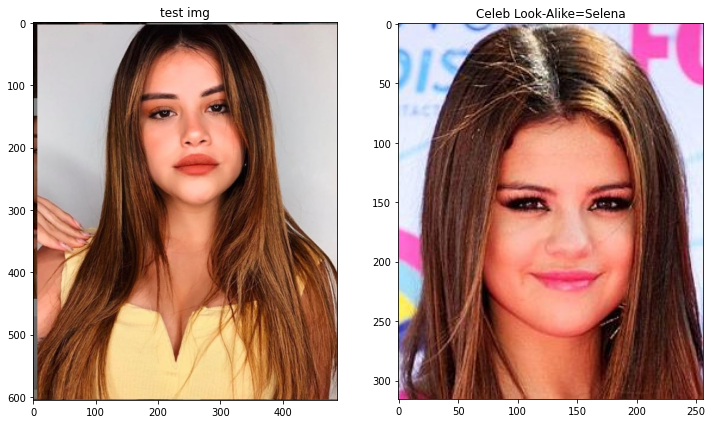

test-images/shashikant-pedwal.jpg
max cosine similiarity 0.930192831887198
celeb_mini/n00000102/n00000102_00000588.JPEG
Amitabh Bachchan


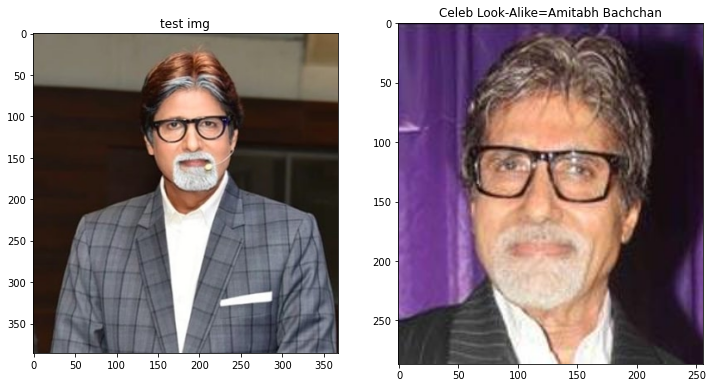

In [48]:
from numpy import dot
from numpy.linalg import norm
# read image
testImages = glob.glob('test-images/*.jpg')

test_descriptors = []
test_face_array=[]

for test in testImages:
    print(test)
    im = cv2.imread(test)
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    #####################
    #  YOUR CODE HERE
    dets = faceDetector(imDlib, 1)
    # Now process each face we found.
    for k, d in enumerate(dets):
      # Get the landmarks/parts for the face in box d.
      shape = shapePredictor(imDlib, d)

      # Compute the 128D vector that describes the face in img identified by shape.  
      test_face_descriptor = faceRecognizer.compute_face_descriptor(imDlib, shape)
      #faces_encodings[(filename, labelMap[celeb_ID])] = test_face_descriptor
      descriptor_ratio=[]
      for cds in celeb_face_encoding.values():
        #calculate Cosine Similarity
        cos_sim = dot(cds, test_face_descriptor)/(norm(cds)*norm(test_face_descriptor))
        descriptor_ratio.append(cos_sim)
    
    print("max cosine similiarity",max(descriptor_ratio))
    
    celeb_path=list(celeb_face_encoding)[descriptor_ratio.index(max(descriptor_ratio))][0]
    celeb_path=('celeb_mini/'+celeb_path.split('_')[0]+'/'+celeb_path)
    print(celeb_path)
    celeb_path = cv2.cvtColor(cv2.imread(celeb_path), cv2.COLOR_BGR2RGB)

    celeb_name =list(celeb_face_encoding)[descriptor_ratio.index(max(descriptor_ratio))][1]
    print(celeb_name)
    ####################
    
    plt.subplot(121)
    plt.imshow(imDlib)
    plt.title("test img")
    
    #TODO - display celeb image which looks like the test image instead of the black image. 
    plt.subplot(122)
    #plt.imshow(np.zeros((200,200,3)))
    plt.imshow(celeb_path)
    plt.title("Celeb Look-Alike={}".format(celeb_name))
    plt.show()